In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Input
import os

In [2]:
# Set dataset path
data_dir = r'D:\Project\aug_data\paper_data'

In [3]:
batch_size = 32
img_height = 224
img_width = 224
image_size = (img_height, img_width)
epochs = int(input("Enter epochs number: "))

Enter epochs number:  30


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'  # Force RGB mode
)

Found 171 images belonging to 4 classes.


In [5]:
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 32 images belonging to 4 classes.


In [6]:
model = Sequential([
    Input(shape=(224, 224, 3)),  # Define input explicitly
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [8]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/30
6/6 [==============================] - 14s 800ms/step - loss: 1.7362 - accuracy: 0.3626 - val_loss: 1.2918 - val_accuracy: 0.4375
Epoch 2/30
6/6 [==============================] - 4s 799ms/step - loss: 1.1685 - accuracy: 0.4444 - val_loss: 0.8694 - val_accuracy: 0.6250
Epoch 3/30
6/6 [==============================] - 4s 687ms/step - loss: 0.8485 - accuracy: 0.6608 - val_loss: 0.6074 - val_accuracy: 0.7500
Epoch 4/30
6/6 [==============================] - 5s 739ms/step - loss: 0.5297 - accuracy: 0.7719 - val_loss: 0.4466 - val_accuracy: 0.8125
Epoch 5/30
6/6 [==============================] - 4s 837ms/step - loss: 0.4765 - accuracy: 0.8012 - val_loss: 0.4949 - val_accuracy: 0.7812
Epoch 6/30
6/6 [==============================] - 5s 848ms/step - loss: 0.3633 - accuracy: 0.8421 - val_loss: 0.4069 - val_accuracy: 0.8438
Epoch 7/30
6/6 [==============================] - 6s 1s/step - loss: 0.3888 - accuracy: 0.8246 - val_loss: 0.4138 - val_accuracy: 0.8125
Epoch 8/30
6/6 [======

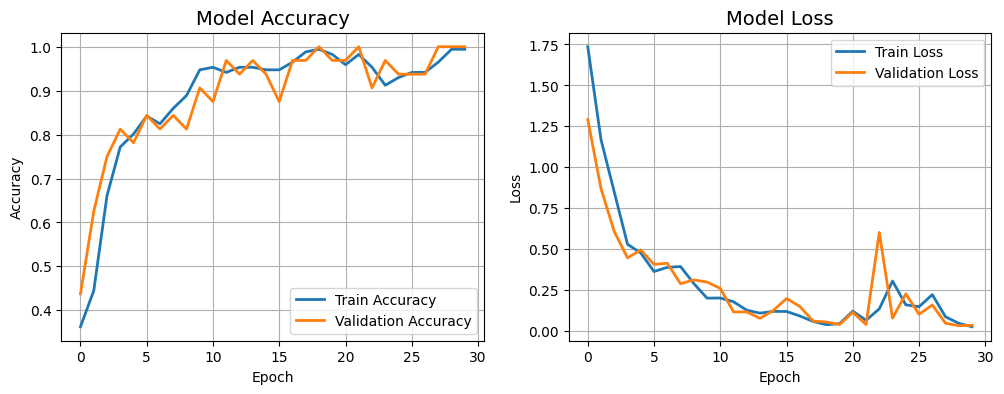

In [10]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

In [11]:
# Evaluate model
eval_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

y_true = eval_generator.classes
y_pred = model.predict(eval_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Fix tf.argmax issue

Found 171 images belonging to 4 classes.


In [12]:
# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
class_labels = list(train_generator.class_indices.keys())


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        45

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



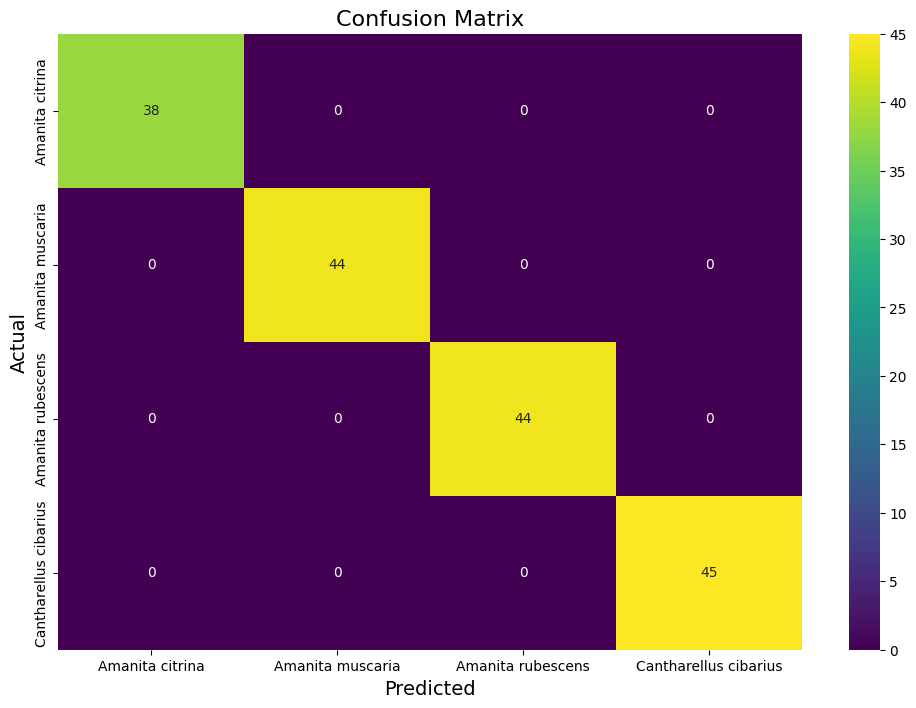

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [14]:
model_version = epochs
next_version = str(int(model_version) + 10) 

In [15]:
import shutil

notebook_filename = f"CNN_{model_version}_ADAM.ipynb"
new_notebook_filename = f"CNN_{next_version}_ADAM.ipynb"

shutil.copy(notebook_filename, new_notebook_filename)
print(f"Notebook copied as {new_notebook_filename}")

Notebook copied as CNN_40_ADAM.ipynb


In [ ]:
os._exit(00)